In [1]:
import sys
import os
from pathlib import Path

# Automatically find the project root (assumes "src" is in the project)
current_file = Path(__file__).resolve() if '__file__' in locals() else Path.cwd()
project_root = current_file
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

# Ensure we found the correct project root
if not (project_root / "src").exists():
    raise FileNotFoundError("Could not find project root containing 'src' directory.")

# Set the working directory to the project root
os.chdir(project_root)
from src.compression.mps_ND import NDMPS
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from src.compression.utils_ND import *
import pickle as pkl
from copy import deepcopy

/Users/maxge/miniconda3/envs/QEL/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
mri_file = 'Data/MRI Dataset/sub-01_T1w.nii.gz'
img = nib.load(mri_file)
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.ndarray'>
(160, 192, 192)


(192, 192)


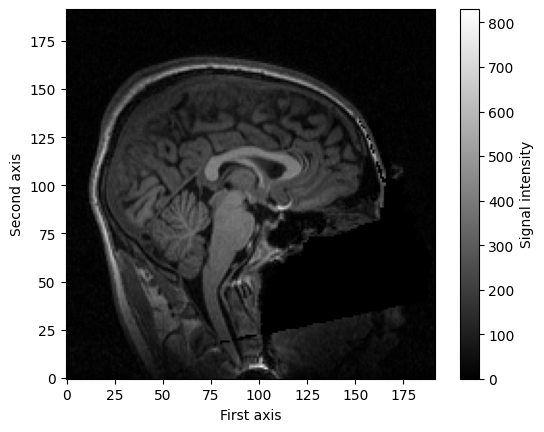

In [3]:
mid_slice_x = img_data[80, :, :]
print(mid_slice_x.shape)
# Note that the transpose the slice (using the .T attribute).
# This is because imshow plots the first dimension on the y-axis and the
# second on the x-axis, but we'd like to plot the first on the x-axis and the
# second on the y-axis. Also, the origin to "lower", as the data was saved in
# "cartesian" coordinates.
plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

In [4]:
mps = NDMPS.from_tensor(img_data, norm = False, mode="Std")

/Users/maxge/Documents/01_Studium/04_München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/src/compression/utils_ND.py:82: RuntimeWarning: invalid value encountered in cast
  prod_block_sizes[0] = prod_block_sizes [0] * 1e100


In [5]:
mps.compression_ratio()

np.float64(1.4237521701388889)

In [6]:
mps.continuous_compress(0.1)

Compression ratio at 0.001: 1.4237521701388889
Compression ratio at 0.005000000000000001: 1.4237521701388889
Compression ratio at 0.010000000000000002: 1.4201063368055555
Compression ratio at 0.020000000000000004: 1.2068250868055554
Compression ratio at 0.05: 0.2758151584201389
Compression ratio at 0.08000000000000002: 0.07201063368055556
Compression ratio at 0.1: 0.034012858072916666


In [7]:
mps.compression_ratio()

np.float64(0.034012858072916666)

In [8]:
recovered_img = mps.to_tensor()

y: 10:220
z: :175
x: 40:200

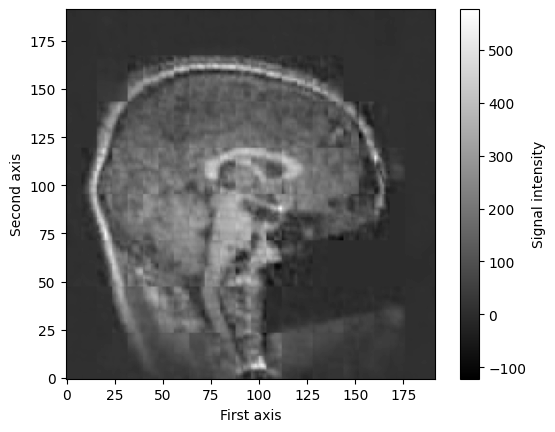

In [9]:
plt.imshow(recovered_img[80,:,:].T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

In [10]:
calc_PSNR(img_data, recovered_img)

np.float64(33.241029316147774)

In [36]:
compute_ssim_2D(img_data, recovered_img)

np.float64(0.87896481328985)

In [37]:
avg_SSIM_3D(img_data, recovered_img)

np.float64(0.6895884201921264)

In [11]:
from src.evaluation.benchmark import load_tensors

In [12]:
ped = load_tensors(["Data/pedestrians/seq_00000.npz"], ".npz", shape = (200,144,216))
ped_tensor = ped[0][0]
ped_tensor.shape

Loading file 1/1


(200, 144, 216)

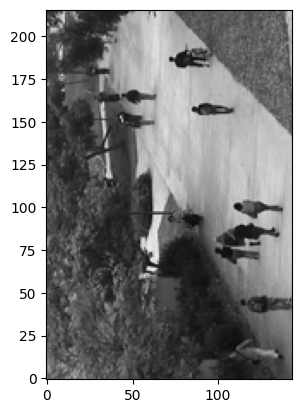

In [13]:
plt.imshow(ped_tensor[100, :, :].T, cmap='gray', origin='lower')

In [14]:
mps_ped = NDMPS.from_tensor(ped_tensor, norm = False, mode="Std")

/Users/maxge/Documents/01_Studium/04_München/02_SS 2024/QEL/Block encoding generalization/img-compression-mps/src/compression/utils_ND.py:82: RuntimeWarning: invalid value encountered in cast
  prod_block_sizes[0] = prod_block_sizes [0] * 1e100


In [15]:
mps_ped.compression_ratio()

np.float64(1.2451131687242798)

In [27]:
mps_ped.compress_to_dtype(np.uint8, replace=True)

[array([[ 97, 150, 130, 113, 135, 116, 122, 187, 125, 213,  81, 123, 128,
         126, 127,   1],
        [ 99, 124,  92,  90, 148, 230, 151, 113, 124, 130, 119, 123, 126,
           2, 127, 126],
        [ 97, 113, 207, 178,  77, 163, 158, 123, 122, 130, 116, 125, 120,
         126, 250, 126],
        [ 69,  75,  84, 198, 150, 127, 100, 138, 253, 133, 146, 130, 123,
         126, 126, 126],
        [101,  87, 185,  88, 159, 137,  84, 168, 118, 105, 169, 122, 255,
         125, 125, 126],
        [ 63, 176,  99,  92,  75,  87, 213, 135, 139, 137, 226, 137, 142,
         125, 126, 126],
        [ 79,  59, 128,  60, 118,  76, 187, 145, 145,  58,  37, 126, 116,
         126, 126, 126],
        [ 72, 188, 157, 141, 201, 112, 121,  91, 118, 100, 106, 246, 121,
         126, 127, 126],
        [ 96, 150, 130, 113, 135, 116, 122, 188, 125, 214,  81, 123, 128,
         126, 126, 249],
        [ 98, 124,  93,  90, 148, 229, 152, 112, 124, 130, 120, 122, 127,
         250, 126, 126],
        [ 

In [28]:
rec_img = mps_ped.to_tensor()

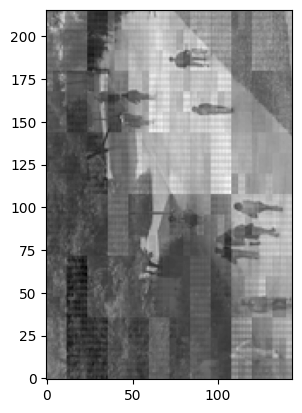

In [29]:
plt.imshow(rec_img[100, :, :].T, cmap='gray', origin='lower')

In [30]:
compute_ssim_2D(ped_tensor, rec_img)

np.float64(0.611892998692896)